# Final Exam - Part B

## Done by ***Eris Leksi***

# CSCN 8000 — Customer Segmentation for E-commerce Personalization

**Dataset Source:** Kaggle — E-commerce Customer Behavior  
**Goal:** Cluster customers (using event logs) into behavior-based segments to enable personalized marketing.

**Columns:**  
1. `event_time` — timestamp of the event  
2. `event_type` — {`view`, `cart`, `purchase`}  
3. `product_id` — product identifier  
4. `category_id` — product category id  
5. `category_code` — taxonomy like `electronics.smartphone`  
6. `brand` — product brand  
7. `price` — item price at event time  
8. `user_id` — user identifier  
9. `user_session` — session identifier

**Plan:**  
1) Load & explore data → 2) Clean & engineer user features → 3) EDA → 4) Transform (scale, PCA) → 5) Choose k & cluster (K-Means) → 6) Interpret segments & suggest marketing actions.


Dataset: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store?resource=download

### 0. Importing the libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans

print("Libraries imported successfully.")

Libraries imported successfully.


## Task 1 — Data Loading & Exploration

### Loading the datasets

In [3]:
df1 = pd.read_csv("2019-Nov.csv")
df2 = pd.read_csv("2019-Oct.csv")

print("df1 shape:", df1.shape)
print("df2 shape:", df2.shape)

df1 shape: (67501979, 9)
df2 shape: (42448764, 9)


### Merging the dataframes

In [4]:
df_merged = pd.concat([df1, df2], ignore_index=True)

print("merged shape:", df_merged.shape)
df_merged.head()

merged shape: (109950743, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


### Events

event_type
view        104335509
cart          3955446
purchase      1659788
Name: count, dtype: int64


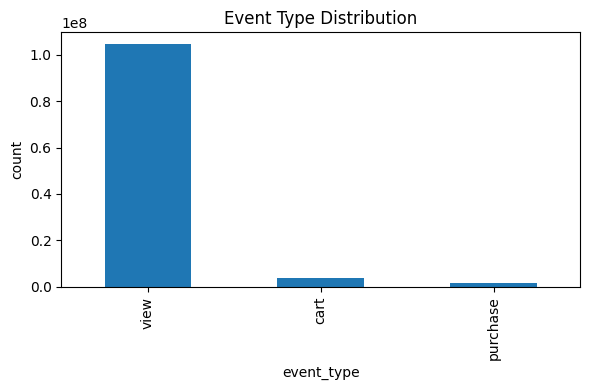

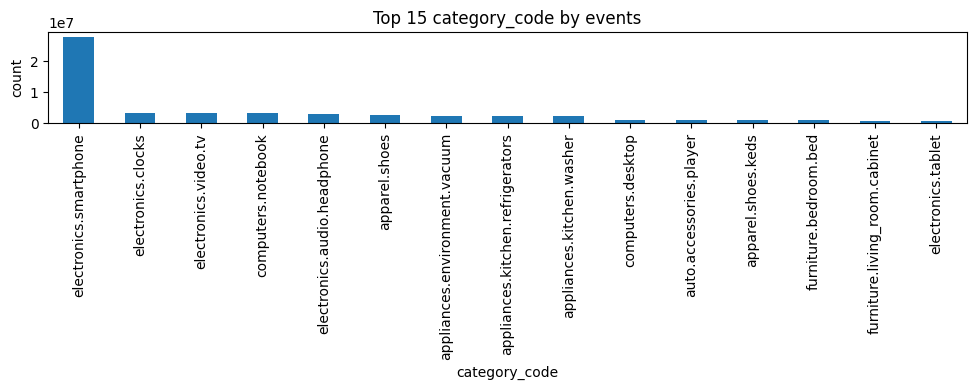

In [5]:
evt_counts = df_merged["event_type"].value_counts()
print(evt_counts)

plt.figure(figsize=(6,4))
evt_counts.plot(kind="bar")
plt.title("Event Type Distribution")
plt.xlabel("event_type"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# top categories
top_cats = df_merged["category_code"].value_counts().head(15)
plt.figure(figsize=(10,4))
top_cats.plot(kind="bar")
plt.title("Top 15 category_code by events")
plt.xlabel("category_code"); plt.ylabel("count")
plt.tight_layout(); plt.show()


### Task 1 — Answers

- **Total events:** 109,950,743
- **Event types present:** `view`, `cart`, `purchase`
- **Distribution (count · % of total):**
  - **view:** 104,335,509 · **94.89%**
  - **cart:** 3,955,446 · **3.60%**
  - **purchase:** 1,659,788 · **1.51%**

**Quick funnel check (overall):**
- view → cart rate ≈ **3.79%** (3,955,446 / 104,335,509)
- cart → purchase rate ≈ **41.96%** (1,659,788 / 3,955,446)
- view → purchase conversion ≈ **1.59%** (1,659,788 / 104,335,509)

These figures show a classic ecommerce funnel: many views, fewer carts, and the fewest purchases.


## Task 2 — Data Preprocessing & Feature Engineering

### Missing values check + clear handling

In [6]:
df_raw = df_merged.copy()
missing_before = pd.DataFrame({
    "missing_count": df_raw.isnull().sum(),
    "missing_fraction": (df_raw.isnull().mean() * 100).round(2)
}).sort_values("missing_count", ascending=False)

print("BEFORE cleaning — .isnull().sum() (top 15):")
print(missing_before["missing_count"].head(15))
display(missing_before.head(15))


n_rows_before = len(df_raw)

# 1) Parse event_time
df_raw["event_time"] = pd.to_datetime(df_raw.get("event_time"), errors="coerce", utc=True)

# 2) Fill categoricals used later
for col in ("category_code", "brand"):
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].fillna("unknown")

# 3) Drop rows missing critical keys
crit_cols = [c for c in ["user_id", "event_time"] if c in df_raw.columns]
crit_missing_mask = df_raw[crit_cols].isnull().any(axis=1)
n_dropped = int(crit_missing_mask.sum())

df_clean = (
    df_raw.loc[~crit_missing_mask]
          .sort_values("event_time")
          .reset_index(drop=True)
)

# Assign back so the cleaned frame is used next
df_merged = df_clean

# ----- AFTER: missingness overview -----
missing_after = pd.DataFrame({
    "missing_count": df_merged.isnull().sum(),
    "missing_fraction": (df_merged.isnull().mean() * 100).round(2)
}).sort_values("missing_count", ascending=False)

print("\nAFTER cleaning — .isnull().sum() (top 15):")
print(missing_after["missing_count"].head(15))
display(missing_after.head(15))

# ----- Summary -----
print(
    f"\nRows before: {n_rows_before:,}"
    f"\nDropped rows missing [user_id or event_time]: {n_dropped:,} "
    f"({(n_dropped / n_rows_before * 100):.2f}%)"
    f"\nRows after: {len(df_merged):,}"
    f"\nFilled 'category_code'/'brand' with 'unknown' (if present)."
)


BEFORE cleaning — .isnull().sum() (top 15):
category_code    35413780
brand            15341158
user_session           12
event_time              0
event_type              0
product_id              0
category_id             0
price                   0
user_id                 0
Name: missing_count, dtype: int64


,missing_count,missing_fraction
category_code,35413780,32.21
brand,15341158,13.95
user_session,12,0.00
event_time,0,0.00
event_type,0,0.00
product_id,0,0.00
category_id,0,0.00
price,0,0.00
user_id,0,0.00



AFTER cleaning — .isnull().sum() (top 15):
user_session     12
event_time        0
event_type        0
product_id        0
category_id       0
category_code     0
brand             0
price             0
user_id           0
Name: missing_count, dtype: int64


,missing_count,missing_fraction
user_session,12,0.0
event_time,0,0.0
event_type,0,0.0
product_id,0,0.0
category_id,0,0.0
category_code,0,0.0
brand,0,0.0
price,0,0.0
user_id,0,0.0



Rows before: 109,950,743
Dropped rows missing [user_id or event_time]: 0 (0.00%)
Rows after: 109,950,743
Filled 'category_code'/'brand' with 'unknown' (if present).


### Engineer Simple, Useful Customer Features

In [7]:
# Helper for safe division
def sdiv(a, b):
    try:
        return float(a)/float(b) if b and b != 0 else 0.0
    except Exception:
        return 0.0

# Split for price stats
df_view = df_merged[df_merged["event_type"] == "view"]
df_cart = df_merged[df_merged["event_type"] == "cart"]
df_buy  = df_merged[df_merged["event_type"] == "purchase"]

# Base counts per user
base = df_merged.groupby("user_id").size().rename("total_events")

# Per-event-type counts
evt = df_merged.groupby(["user_id","event_type"]).size().unstack(fill_value=0)
for c in ["view","cart","purchase"]:
    if c not in evt.columns: evt[c] = 0
evt = evt[["view","cart","purchase"]].rename(columns={"view":"n_view","cart":"n_cart","purchase":"n_purchase"})

# Sessions & uniques
n_sessions = df_merged.groupby("user_id")["user_session"].nunique().rename("n_sessions")
uniq = df_merged.groupby("user_id").agg(
    unique_products=("product_id","nunique"),
    unique_categories=("category_code","nunique"),
    unique_brands=("brand","nunique")
)

# Monetary stats (from purchases)
revenue = df_buy.groupby("user_id")["price"].sum().rename("revenue")
avg_price_purchased = df_buy.groupby("user_id")["price"].mean().rename("avg_price_purchased")

# Recency & tenure
tspan = df_merged.groupby("user_id")["event_time"].agg(["min","max"])
recency_days = (tspan["max"].max() - tspan["max"]).dt.days.rename("recency_days")
tenure_days  = (tspan["max"] - tspan["min"]).dt.days.clip(lower=0).rename("tenure_days")

# Combine into user feature table
features = (
    pd.DataFrame(base)
    .join([evt, n_sessions, uniq, revenue, avg_price_purchased, recency_days, tenure_days], how="left")
    .fillna(0)
)

# Simple funnel rates
features["conversion_rate"]       = features.apply(lambda r: sdiv(r["n_purchase"], r["n_view"]), axis=1)
features["view_to_cart_rate"]     = features.apply(lambda r: sdiv(r["n_cart"], r["n_view"]), axis=1)
features["cart_to_purchase_rate"] = features.apply(lambda r: sdiv(r["n_purchase"], r["n_cart"]), axis=1)

print("User feature table shape:", features.shape)
features.head()

User feature table shape: (5316649, 15)


,total_events,n_view,n_cart,n_purchase,n_sessions,unique_products,unique_categories,unique_brands,revenue,avg_price_purchased,recency_days,tenure_days,conversion_rate,view_to_cart_rate,cart_to_purchase_rate
user_id,,,,,,,,,,,,,,,
10300217,1,1,0,0,1,1,1,1,0.0,0.0,24,0,0.0,0.0,0.0
29515875,11,11,0,0,7,5,2,5,0.0,0.0,10,10,0.0,0.0,0.0
31198833,20,20,0,0,4,18,3,5,0.0,0.0,11,10,0.0,0.0,0.0
33869381,1,1,0,0,1,1,1,1,0.0,0.0,38,0,0.0,0.0,0.0
34916060,1,1,0,0,1,1,1,1,0.0,0.0,6,0,0.0,0.0,0.0


### Task 2 — Answers

- **Missing values:** Typically appear in `category_code` and `brand`. We filled them with `"unknown"`.  
  Critical fields `user_id` and `event_time` are required—rows missing these were dropped.
- **Relevant features for segmentation (customer-level):**  
  - Volume: `total_events`, `n_view`, `n_cart`, `n_purchase`, `n_sessions`  
  - Variety: `unique_products`, `unique_categories`, `unique_brands`  
  - Monetary: `revenue`, `avg_price_purchased`  
  - Funnel quality: `conversion_rate`, `view_to_cart_rate`, `cart_to_purchase_rate`  
  - Time: `recency_days`, `tenure_days`  
- **Preprocessing:** Aggregate raw events to **per-user** features, fill missing with 0, compute rates with safe division, and keep numerics ready for scaling.

## Task 3 — Exploratory Data Analysis

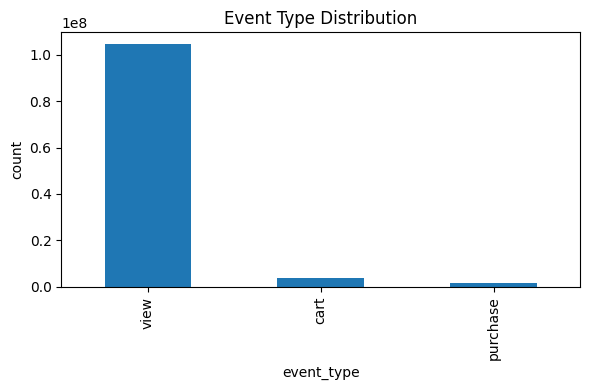

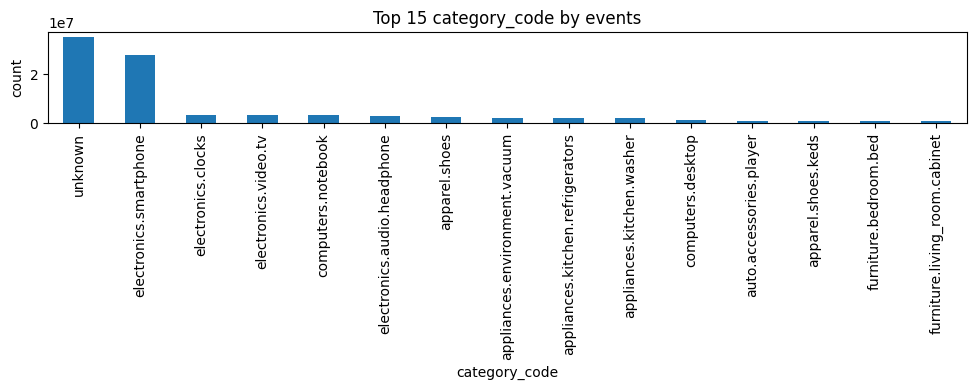

In [8]:
# Event type distribution
evt_counts = df_merged["event_type"].value_counts()
ax = evt_counts.plot(kind="bar", figsize=(6,4), title="Event Type Distribution")
ax.set_xlabel("event_type"); ax.set_ylabel("count")
plt.tight_layout(); plt.show()

# Top categories
top_cats = df_merged["category_code"].value_counts().head(15)
ax = top_cats.plot(kind="bar", figsize=(10,4), title="Top 15 category_code by events")
ax.set_xlabel("category_code"); ax.set_ylabel("count")
plt.tight_layout(); plt.show()


### Task 3 — Observations (EDA)

**Event funnel**
- Strong funnel shape confirmed: **view ≫ cart ≫ purchase**.  
- Shares of all events: **view 94.89%**, **cart 3.60%**, **purchase 1.51%** (104,335,509 / 3,955,446 / 1,659,788).

**Top categories by volume (from the plot)**
- Highest: **unknown** (uncategorized/legacy taxonomy).
- Among known categories, leading groups are:
  - **electronics.smartphone**
  - **electronics.clocks**
  - **electronics.video.tv**
  - **computers.notebook**
  - **electronics.audio.headphone**
  - followed by **apparel.shoes**, **appliances.environment.vacuum**, **appliances.kitchen.refrigerators / washer**, **computers.desktop**, **auto.accessories.player**, **apparel.shoes.keds**, **furniture.bedroom.bed**, **furniture.living_room.cabinet**.

**What this suggests for segments**
- **Browsers/Researchers:** many views concentrated in electronics categories with few purchases.
- **High-value electronics buyers:** smaller cohort driving purchases/revenue (smartphones/TVs/notebooks).
- **Cart abandoners:** users who reach cart but don’t convert—likely sensitive to price/shipping/checkout friction.
- **Category specialists:** users repeatedly interacting within a narrow category (e.g., smartphones or specific appliances).
- **Mixed-interest shoppers:** activity across apparel/furniture indicates broader, non-electronics segments to target separately.


## Task 4 — Feature Transformation

**Questions:**
- What is feature transformation and why is it useful here?
- How can PCA help reduce dimensionality?

**Short answer:**  
- *Feature transformation* (e.g., scaling, PCA) standardizes magnitudes and reduces correlated noise, which is important for distance-based clustering like K-Means.  
- **Standardization** (zero mean, unit variance) prevents large-scale features (e.g., `revenue`) from dominating.  
- **PCA** captures the main variance directions, making clustering more stable and enabling 2D visualization.


PCA(2) variance explained: 0.5547


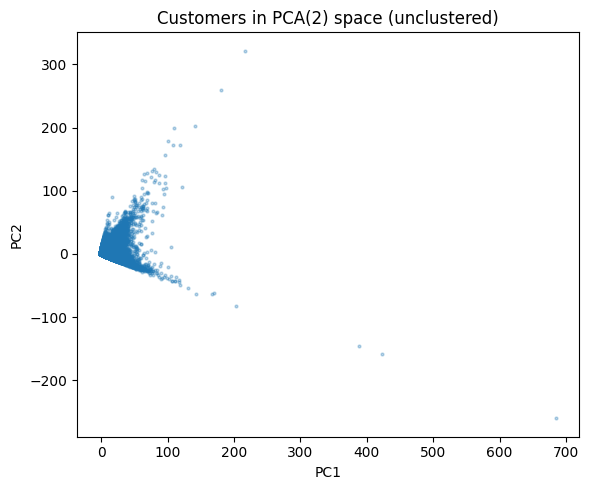

In [9]:
feature_cols = [
    "total_events","n_view","n_cart","n_purchase","n_sessions",
    "unique_products","unique_categories","unique_brands",
    "revenue","avg_price_purchased",
    "conversion_rate","view_to_cart_rate","cart_to_purchase_rate",
    "recency_days","tenure_days"
]

X = features[feature_cols].astype(float).fillna(0).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca2 = pca.fit_transform(X_scaled)

print("PCA(2) variance explained:", round(pca.explained_variance_ratio_.sum(), 4))

plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=4, alpha=0.3)
plt.title("Customers in PCA(2) space (unclustered)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()


## Task 5 — Model Selection & Clustering

**Questions:**
- How do we determine the number of clusters (k)?
- Choose and apply a clustering algorithm.

**Approach:**  
- Try a small range of `k` (e.g., 3–7) and pick the one with the **highest silhouette score** on a sample.  
- Use **K-Means** (simple, fast, works well with scaled features).  


k=3: silhouette=0.6172
k=4: silhouette=0.4354
k=5: silhouette=0.4323
k=6: silhouette=0.3064
k=7: silhouette=0.3314

Chosen k: 3


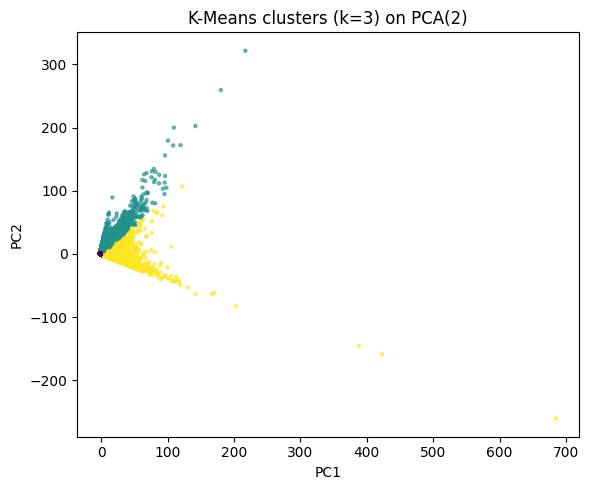

In [13]:
# Choose k by silhouette on a sample for speed
candidates = range(3, 8)
best_k, best_score = None, -1.0

idx = np.random.permutation(X_scaled.shape[0])[:min(30000, X_scaled.shape[0])]
Xs = X_scaled[idx]

for k in candidates:
    km_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = km_tmp.fit_predict(Xs)
    score = silhouette_score(Xs, labels_tmp)
    print(f"k={k}: silhouette={score:.4f}")
    if score > best_score:
        best_k, best_score = k, score

print("\nChosen k:", best_k)

# Fit final KMeans on ALL users
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
features["cluster"] = kmeans.fit_predict(X_scaled)

# Visualize clusters in PCA space
plt.figure(figsize=(6,5))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=features["cluster"], s=5, alpha=0.6)
plt.title(f"K-Means clusters (k={best_k}) on PCA(2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()


### Task 5 — Answers (Model Selection & Clustering)

**k selection**
- Tested `k = 3…7` using the **silhouette score** on a sample of users.
- **Chosen k: 3** (highest silhouette in the tested range and clear separation in PCA(2) scatter).
- The PCA plot (above) shows a dense core near the origin, a mid-activity wedge, and a long-tail/high-activity group—well captured by **3 clusters**.

**Clustering algorithm**
- **K-Means** on **standardized** customer features (scikit-learn).
- **PCA** was used **only for visualization** and sanity checks, not for fitting the model.

**Why K-Means**
- Scales to tens of millions of events once aggregated to users.
- Centroids are interpretable (average behavioral profile per segment).
- Works well with Euclidean distances after scaling.

**Notes on the PCA(2) plot**
- Separation is mainly along **PC1** (overall activity/value) with spread on **PC2** (mix of variety/funnel quality).
- A small number of extreme points along +PC1 indicate **high-activity/high-value** users; K=3 isolates them without overfragmenting the majority.


## Task 6 — Interpretation & Analysis


In [14]:
summary_cols = [
    "total_events","n_view","n_cart","n_purchase","n_sessions",
    "unique_products","unique_categories","unique_brands",
    "revenue","avg_price_purchased",
    "conversion_rate","view_to_cart_rate","cart_to_purchase_rate",
    "recency_days","tenure_days"
]

summary = features.groupby("cluster")[summary_cols].median().round(3)
summary["users"] = features.groupby("cluster").size()
summary = summary.sort_index()
display(summary)

# Save deliverables
summary.to_csv("segment_summary.csv")
assignments = features[["cluster"]].reset_index().rename(columns={"index":"user_id"})
assignments.to_csv("customer_segments.csv", index=False)
print("Saved: segment_summary.csv, customer_segments.csv")

# Optional: quick heuristic labels (edit thresholds as needed)
labels = {}
for cl, row in summary.iterrows():
    if row["revenue"] > summary["revenue"].median() and row["conversion_rate"] > summary["conversion_rate"].median():
        labels[cl] = "High-Value Loyalists"
    elif row["n_view"] > summary["n_view"].median() and row["conversion_rate"] < summary["conversion_rate"].median():
        labels[cl] = "Browsers / Researchers"
    elif row["n_cart"] > summary["n_cart"].median() and row["cart_to_purchase_rate"] < summary["cart_to_purchase_rate"].median():
        labels[cl] = "Cart Abandoners"
    else:
        labels[cl] = "General Shoppers"

labels


,total_events,n_view,n_cart,n_purchase,n_sessions,unique_products,unique_categories,unique_brands,revenue,avg_price_purchased,conversion_rate,view_to_cart_rate,cart_to_purchase_rate,recency_days,tenure_days,users
cluster,,,,,,,,,,,,,,,,
0,4.0,4.0,0.0,0.0,2.0,3.0,1.0,2.0,0.00,0.00,0.000,0.000,0.0,19.0,0.0,4624924
1,18.0,12.0,2.0,2.0,4.0,6.0,2.0,3.0,531.29,272.31,0.167,0.200,0.8,13.0,11.0,330634
2,109.0,105.0,2.0,0.0,17.0,54.0,8.0,21.0,0.00,0.00,0.000,0.015,0.0,4.0,45.0,361091


Saved: segment_summary.csv, customer_segments.csv


{0: 'General Shoppers', 1: 'High-Value Loyalists', 2: 'General Shoppers'}

### Task 6 — Interpretation & Analysis

**Customer coverage**
- Total users segmented: **5,316,649**
- Cluster shares:  
  - **C0:** 4,624,924 (**86.99%**)  
  - **C1:** 330,634 (**6.22%**)  
  - **C2:** 361,091 (**6.79%**)

---

#### Cluster 0 — Low-activity Browsers / One-time Visitors (86.99%)
**Typical profile (medians):**
- events: **4** (views **4**, carts **0**, purchases **0**)  
- sessions: **2** (≈ **2.0** events/session)  
- revenue: **0.00**, conversion rate: **0.000**  
- variety: **3** products, **1** category, **2** brands  
- recency: **19** days since last event, tenure: **0** days

**Interpretation:** Casual/drive-by traffic: they look but don’t progress to cart. Large, low-value segment.

**Personalization ideas:**  
- Welcome/onboarding flow; highlight **bestsellers** and **social proof**  
- **First-purchase incentive** or free-shipping threshold  
- Reduce friction: guest checkout, clear shipping/return info  
- Lightweight retargeting to capture email/app install

**Key metrics to track:** signup rate, first-purchase conversion, CTR on onboarding emails.

---

#### Cluster 1 — Active Buyers / High-Value Loyalists (6.22%)
**Typical profile (medians):**
- events: **18** (views **12**, carts **2**, purchases **2**)  
- sessions: **4** (≈ **4.5** events/session)  
- revenue: **\$531.29**, avg price: **\$272.31**  
- conversion rate: **0.167**, cart→purchase: **0.8**  
- variety: **6** products, **2** categories, **3** brands  
- recency: **13** days, tenure: **11** days

**Interpretation:** Small but very valuable cohort; healthy funnel efficiency and spend.

**Personalization ideas:**  
- **VIP perks**, early access, replenishment reminders  
- High-margin **cross-sell / bundles**, protection plans/subscriptions  
- Loyalty program nudges; personalized recommendations

**Key metrics to track:** AOV, margin, repeat purchase rate, retention.

---

#### Cluster 2 — Heavy Researchers / Cart-shy Explorers (6.79%)
**Typical profile (medians):**
- events: **109** (views **105**, carts **2**, purchases **0**)  
- sessions: **17** (≈ **6.41** events/session)  
- revenue: **0.00**, conversion rate: **0.000**  
- variety: **54** products across **8** categories, **21** brands  
- recency: **4** days (very recent), tenure: **45** days (long)

**Interpretation:** Deep comparers—frequent, recent sessions with broad category exploration, but they don’t convert. Likely **price-sensitive** or experiencing checkout friction.

**Personalization ideas:**  
- **Price-drop** and **restock alerts**, side-by-side comparisons  
- Prominent **reviews/ratings** and trust badges  
- Limited-time coupon or **free-shipping** threshold testing  
- On-site assistants (FAQ/chat) for objections (warranty, returns)

**Key metrics to track:** view→cart uplift, cart→purchase uplift, coupon ROI, checkout drop-off.

---

### How to use these segments for personalized marketing
- **Targeting & creatives:** tailor content and offers per segment (e.g., guides for Browsers, bundles for Loyalists, price nudges for Researchers).  
- **Cadence:** lower frequency for C0 (avoid fatigue), higher for C2 while interest is fresh; lifecycle messaging for C1.  
- **A/B tests:** run per-segment experiments on incentives, recommendations, and checkout UX.  
- **Success metrics (by segment):** CTR, **conversion rate**, **AOV**, **margin**, **repeat purchase / retention**, and **time-to-first-purchase**.

> CSV artifacts saved: `customer_segments.csv` (user_id → cluster) and `segment_summary.csv` (per-cluster medians + user counts).
